# Goals of this notebook are: 

* to explore the data set
* perform exploratory data analysis (EDA) on the text part
* perform an EDA on the product type part

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from wordcloud import WordCloud

%matplotlib inline

# Directory Variables

In [2]:
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

# Get the Data

### Read Train.csv as a dataframe called train_descr

In [3]:
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

### Check out the info(), head(), and describe() methods on train_descr**

In [4]:
train_descr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Text_ID              6364 non-null   int64 
 1   Product_Description  6364 non-null   object
 2   Product_Type         6364 non-null   int64 
 3   Sentiment            6364 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 199.0+ KB


Although info already shows that there are no null entries, below once other way to check

In [5]:
train_descr.isnull().sum()

Text_ID                0
Product_Description    0
Product_Type           0
Sentiment              0
dtype: int64

In [6]:
train_descr.head()

,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2
3,4422,The lesson from Google One Pass: In this digit...,9,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2


In [7]:
train_descr.describe()

,Text_ID,Product_Type,Sentiment
count,6364.000000,6364.000000,6364.000000
mean,4568.862822,7.462445,2.230673
std,2621.198346,2.440492,0.638413
min,1.000000,0.000000,0.000000
25%,2297.750000,6.000000,2.000000
50%,4587.500000,9.000000,2.000000
75%,6827.500000,9.000000,3.000000
max,9092.000000,9.000000,3.000000


# Exploratory Data Analysis

### Non-text data

The plot below shows an imbalance in the targets.
As there are a few data samples, the issue of imbalance will be addressed by oversampling the minority classes (see notebook 02_NLP_Model_Choice_Optimisation)

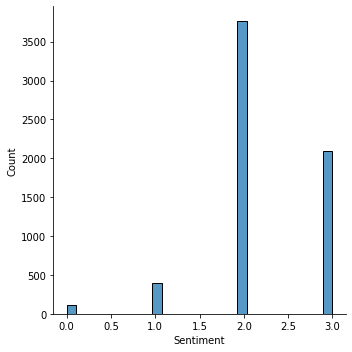

In [8]:
sns.displot(train_descr, x="Sentiment")

Source: https://machinelearningmastery.com/multi-class-imbalanced-classification/

Class=2, n=3765 (59.161%)
Class=1, n=399 (6.270%)
Class=3, n=2089 (32.825%)
Class=0, n=111 (1.744%)


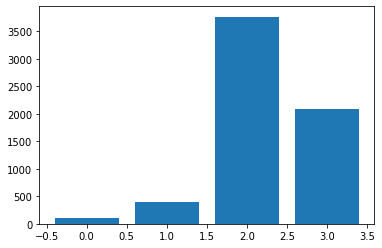

In [9]:
from collections import Counter

y = train_descr.loc[:, 'Sentiment']

# summarize distribution
counter = Counter(y)
for k, v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

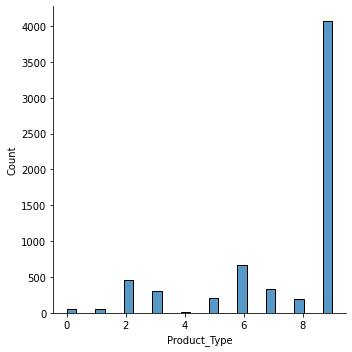

In [10]:
sns.displot(train_descr, x="Product_Type")

### Text Data

In [11]:
sentiment_descr_list = train_descr.loc[:, [
    'Sentiment', 'Product_Description']].values.tolist()

In [12]:
len(sentiment_descr_list)

6364

In [13]:
sentiment_descr_array = np.array(sentiment_descr_list)
sentiment_descr_array

array([['2',
        'The Web Designer\x89Ûªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw'],
       ['2',
        'RT @mention Line for iPad 2 is longer today than yesterday. #SXSW  // are you getting in line again today just for fun?'],
       ['2',
        'Crazy that Apple is opening a temporary store in Austin tomorrow to handle the rabid #sxsw eye pad too seekers.'],
       ...,
       ['2',
        'RT @mention RT @mention Download 20+ free tracks from @mention Music Sampler @mention including @glove! {link} #SXSW'],
       ['2',
        "OH at Texas Social Media Awards: 'You don't need to ask your mother anymore. Just Google it.' #sxswi #sxsw"],
       ['2',
        '#Google launching a &quot;major&quot; new social network at #sxsw ... Wonder what that can be...']],
      dtype='<U178')

#### Take a look at the lengths of the different product descriptions

It is important, as the input data needs to be of the same length for the models trained later.

In [14]:
for index, descr in enumerate(sentiment_descr_array[:16]):
    print("Index: {} Length: {}".format(index, len(descr[1])))

Index: 0 Length: 89
Index: 1 Length: 119
Index: 2 Length: 111
Index: 3 Length: 137
Index: 4 Length: 87
Index: 5 Length: 137
Index: 6 Length: 112
Index: 7 Length: 115
Index: 8 Length: 90
Index: 9 Length: 110
Index: 10 Length: 96
Index: 11 Length: 121
Index: 12 Length: 99
Index: 13 Length: 134
Index: 14 Length: 125
Index: 15 Length: 104


In [15]:
type(sentiment_descr_array)

numpy.ndarray

min 11
mean 104.64346323067254
std 27.28305668307883
max 178


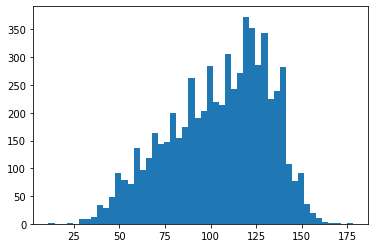

In [16]:
lengths = [len(x[1]) for x in sentiment_descr_array]
print("min", np.min(lengths))
print("mean", np.mean(lengths))
print("std", np.std(lengths))
print("max", np.max(lengths))
plt.hist(lengths, bins=50)
plt.show()
plt.close()

The following is visible in Jupyter Notebook. Below is only a picture in order to show the result - histogram of the text length distribution

In [17]:
from plotly.offline import iplot

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [18]:
pd.Series([len(descr) for descr in train_descr.loc[:, 'Product_Description']]).iplot(
    kind='hist',
    bins=100,
    xTitle='description length',
    linecolor='black',
    yTitle='count',
    title='Description Text Length Distribution')

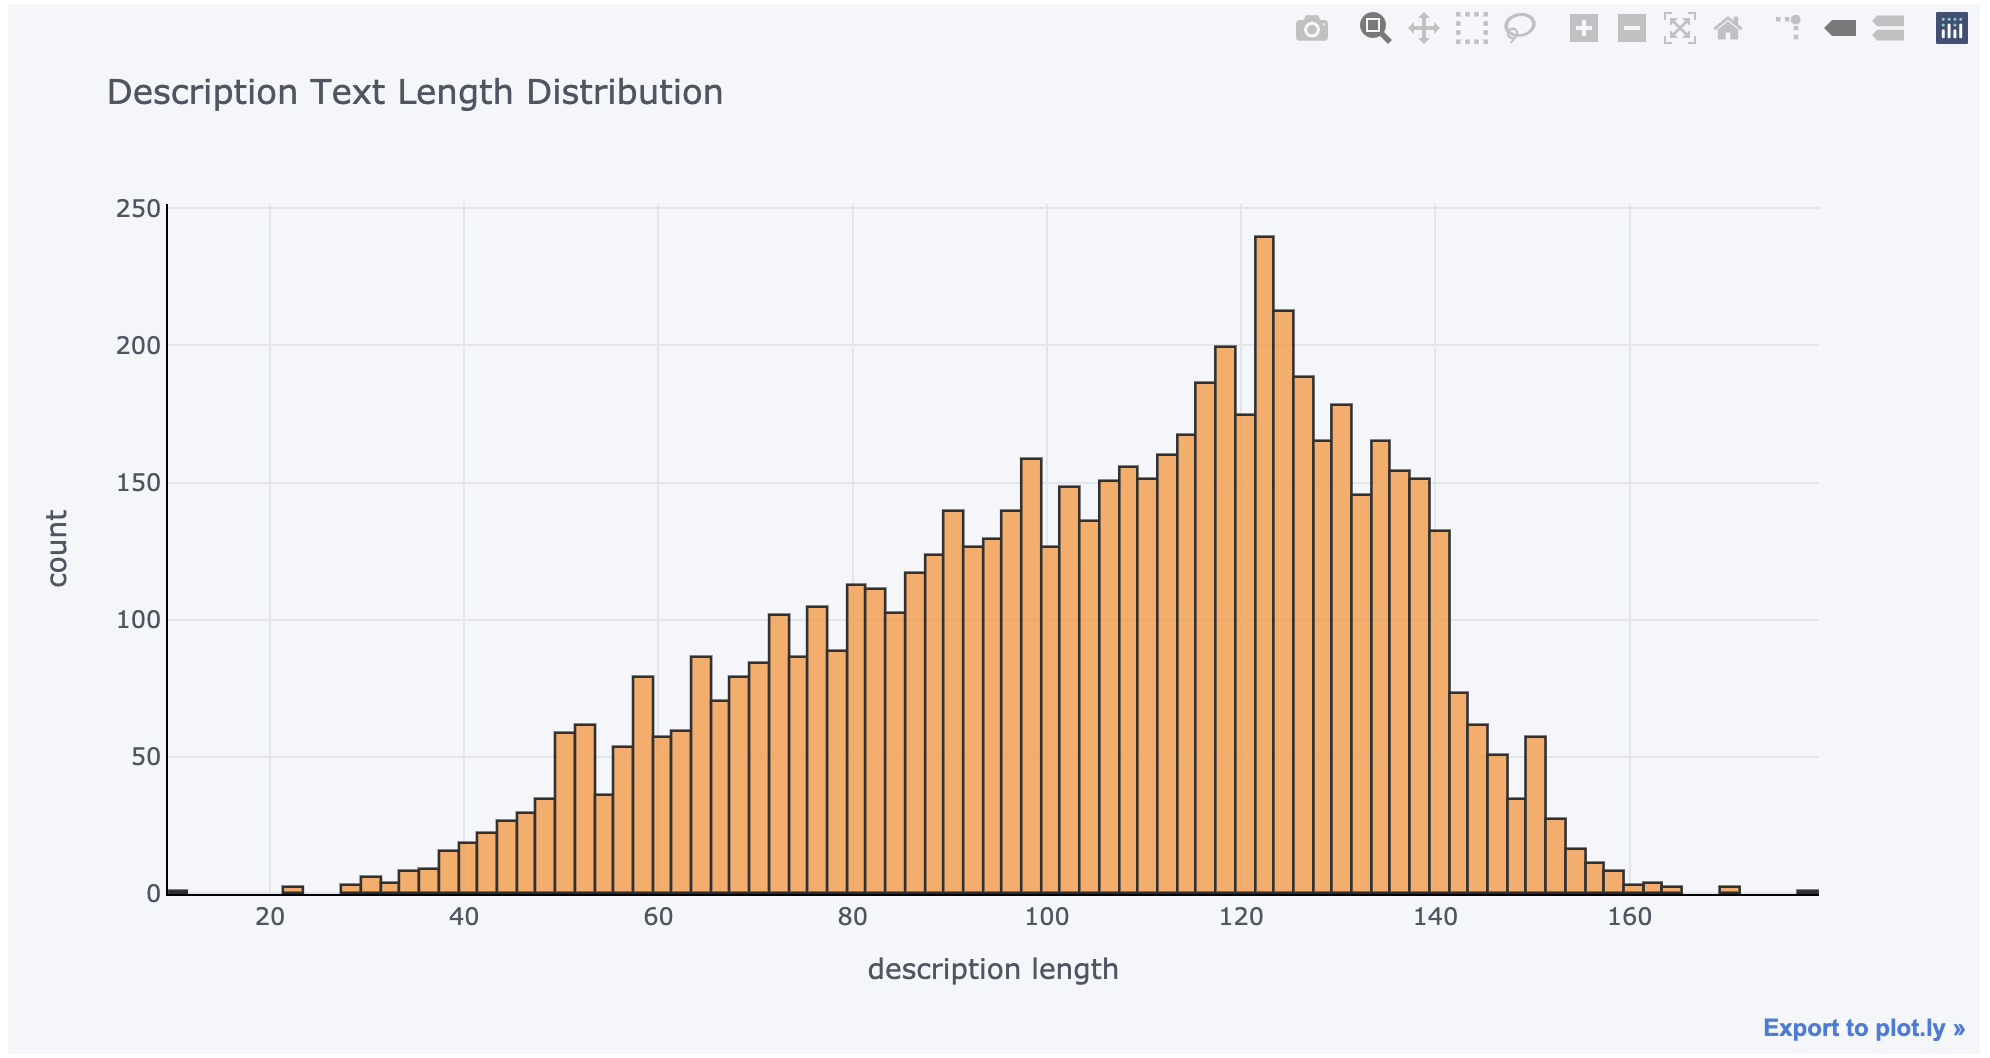

#### Create a Wordcloud to visualise the most frequent words

Source: https://medium.com/@harinisureshla/wordclouds-basics-of-nlp-5b60be226414

In [19]:
text = train_descr.loc[:, 'Product_Description'].values

In [20]:
text2 = ' '.join(train_descr.loc[:, 'Product_Description'])

In [21]:
from wordcloud import WordCloud

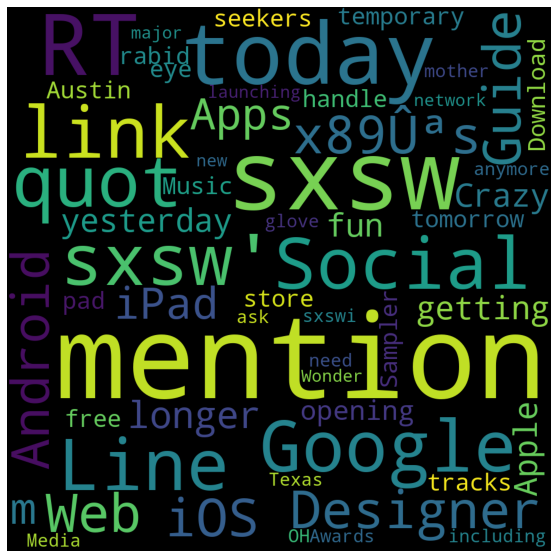

In [22]:
wordcloud = WordCloud(width=1000, height=1000).generate(str(text))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Among the most frequent words is the abreviation **sxsw**. According to wikipedia it is "South by Southwest, stylized as SXSW and colloquially referred to as South By, is an annual conglomeration of parallel film, interactive media, and music festivals and conferences organized jointly that take place in mid-March in Austin, Texas, United States." (https://en.wikipedia.org/wiki/South_by_Southwest). 

Due to the technical theme of the descriptions, I will leave the word. The same also for x89 (a tablet model).

In [23]:
products = train_descr.loc[:, 'Product_Type'].unique()
products.sort()
text_per_prod = train_descr.loc[:, 'Product_Description'].values

Source: https://stackoverflow.com/questions/34165130/side-by-side-wordclouds-in-matplotlib

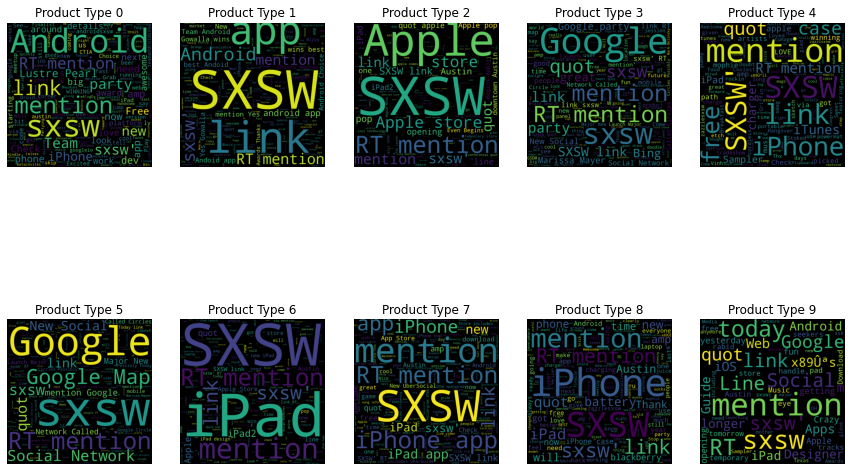

In [24]:
# Plotting word cloud for each product
n_product_types = len(products)

fig = plt.figure(figsize=(15, 10))
for i in range(n_product_types):
    ax = fig.add_subplot(2, 5, i+1)
    product_mask = train_descr.loc[:, 'Product_Type'] == products[i]
    wordcloud_prod = WordCloud(width=1000, height=1000).generate(
        str(train_descr.loc[product_mask, 'Product_Description'].values))
    ax.imshow(wordcloud_prod)
    ax.axis("off")
    ax.title.set_text(f'Product Type {products[i]}')

# Conclusion EDA

* the data set is small --> cross-validation to ensure better results
* the target = sentiment is imbalanced --> oversampling of the minority classes in order also to increase the data set volume
* the text part consists of short messages and specific words --> pre-trained embeddings can be tried in order to introduce more variability into the model
* the non-text part consists of only one feature - product type
* the final model will be a multi-input one - consisting of a model tackling the text part (NLP) and one tackling the non-text part

### On the Side: Just for Fun - Visualising the Wordcloud In a Particular Shape Using a Picture as a Mask 

In [25]:
from PIL import Image

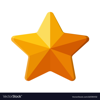

In [26]:
Image.open('photo.jpg').resize((100, 100))

In [27]:
mask = np.array(Image.open('photo.jpg'))

In [28]:
wordcloud_fun = WordCloud(width=1000, height=1080,
                          background_color='white',
                          mask=mask,
                          min_font_size=10).generate(str(text))

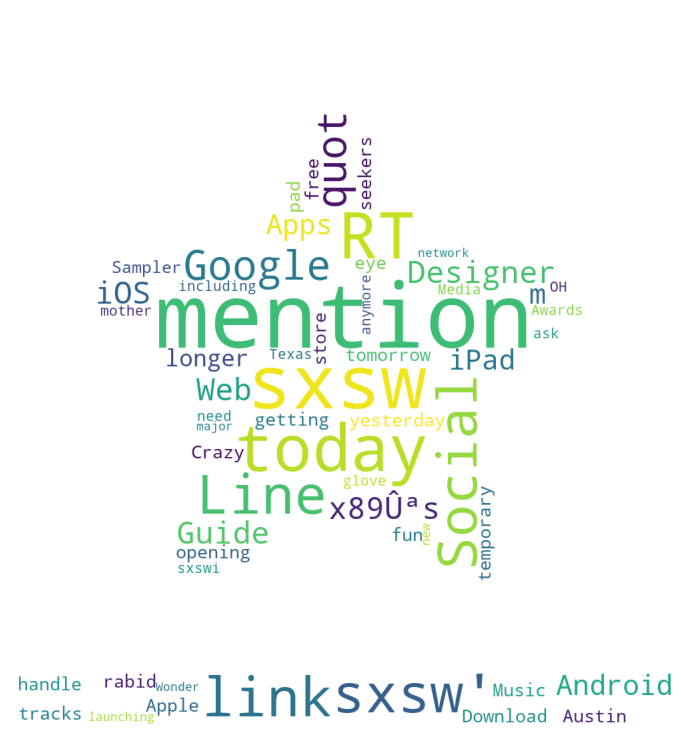

In [30]:
fig = plt.figure(figsize=(10, 10), facecolor='white', edgecolor='blue')
plt.imshow(wordcloud_fun)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

fig.savefig('text_star')